https://keras.io/examples/vision/pointnet/

https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/pointnet.ipynb

https://medium.com/@luis_gonzales/an-in-depth-look-at-pointnet-111d7efdaa1a

PointNet consumes raw point cloud data. Therefore, architecture that conformed to the unique properties of point sets.

1. Permutation (Order) Invariance: given the unstructured nature of point cloud data, a scan made up of N points has N! permutations. The subsequent data processing must be invariant to the different representations.

2. Transformation Invariance: classification and segmentation outputs should be unchanged if the object undergoes certain transformations, including rotation and translation.

3. Point Interactions: the interaction between neighboring points often carries useful information (i.e., a single point should not be treated in isolation). Whereas classification need only make use of global features, segmentation must be able to leverage local point features along with global point features.

https://web.stanford.edu/~rqi/pointnet/docs/cvpr17_pointnet_slides.pdf

In [1]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

tf.random.set_seed(1234)

In [2]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

In [3]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

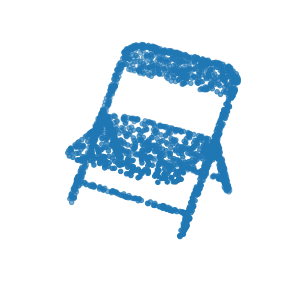

In [4]:
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.gca(projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [5]:
#To create a 3d dataset = parse ModelNet data = load mesh -> sampled into point cloud 
#converted to an numpy array

In [6]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [7]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

processing class: bathtub
processing class: bed
processing class: chair
processing class: night_stand
processing class: sofa
processing class: table
processing class: toilet


In [8]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

Model
-> Convolution Layer + Fully connected Layer
->Last Layer - Convolution + Dense + Batch Normaization + RelU Activation

PointNet has 2 core componets. 
1) MLP NW
2) Trnasformer Net

T-Net aims to learn an affine transformation matrix (?)
T-Net is used twice
First, transform input features (n, 3) into a canonical representation.
Second, affine transformation for alignment in feature space (n, 3)


MLP: Maps each of the n points from 3D (x, y, z) coordinates to 64 dimensions.
1. MLP shared for each of the n points (identical and independent mapping of points)
2. The process is repeated to map n points from 64 dimensions to 1024 dimensions.

-> With points in higher-dimensional embedding space, max pooling is used to create global feature vector in R1024
-> A 3-layer Fully Connected NW is used to map the global feature vector to k output classification scores.
Each of then input points needs to be assigned to one of the m segmentation classes.
Segmentation relies on local/global features, so the points in the 64D embedding space (local) 
are concatenated with global feature vectors. MLPs are used on n points to lower dimensionality from 1024 to 128 and again m (classes)


MODEL

In [9]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))
    
    

In [10]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [11]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2048, 3)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2048, 32)     128         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2048, 32)     128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 2048, 32)     0           batch_normalization[0][0]        
___________________________________________________________________________________________

In [12]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
98/98 [==============================] - 433s 4s/step - loss: 3.4458 - sparse_categorical_accuracy: 0.3250 - val_loss: 135559929856.0000 - val_sparse_categorical_accuracy: 0.2862
Epoch 2/20
98/98 [==============================] - 437s 4s/step - loss: 2.7916 - sparse_categorical_accuracy: 0.4245 - val_loss: 2.6978 - val_sparse_categorical_accuracy: 0.3538
Epoch 3/20
98/98 [==============================] - 433s 4s/step - loss: 2.5924 - sparse_categorical_accuracy: 0.4702 - val_loss: 792252.0000 - val_sparse_categorical_accuracy: 0.3506
Epoch 4/20
98/98 [==============================] - 453s 5s/step - loss: 2.4672 - sparse_categorical_accuracy: 0.5189 - val_loss: 2257652023296.0000 - val_sparse_categorical_accuracy: 0.4591
Epoch 5/20
98/98 [==============================] - 432s 4s/step - loss: 2.3949 - sparse_categorical_accuracy: 0.5707 - val_loss: 43201716174273975943168.0000 - val_sparse_categorical_accuracy: 0.6903
Epoch 6/20
98/98 [==============================] - 434

pred: C:\Users\surya\.keras\datasets\ModelNet10\table, label: C:\Users\surya\.keras\datasets\ModelNet10\bathtub
pred: C:\Users\surya\.keras\datasets\ModelNet10\chair, label: C:\Users\surya\.keras\datasets\ModelNet10\toilet
pred: C:\Users\surya\.keras\datasets\ModelNet10\bed, label: C:\Users\surya\.keras\datasets\ModelNet10\table
pred: C:\Users\surya\.keras\datasets\ModelNet10\bed, label: C:\Users\surya\.keras\datasets\ModelNet10\sofa
pred: C:\Users\surya\.keras\datasets\ModelNet10\chair, label: C:\Users\surya\.keras\datasets\ModelNet10\sofa
pred: C:\Users\surya\.keras\datasets\ModelNet10\chair, label: C:\Users\surya\.keras\datasets\ModelNet10\toilet
pred: C:\Users\surya\.keras\datasets\ModelNet10\chair, label: C:\Users\surya\.keras\datasets\ModelNet10\toilet
pred: C:\Users\surya\.keras\datasets\ModelNet10\chair, label: C:\Users\surya\.keras\datasets\ModelNet10\night_stand


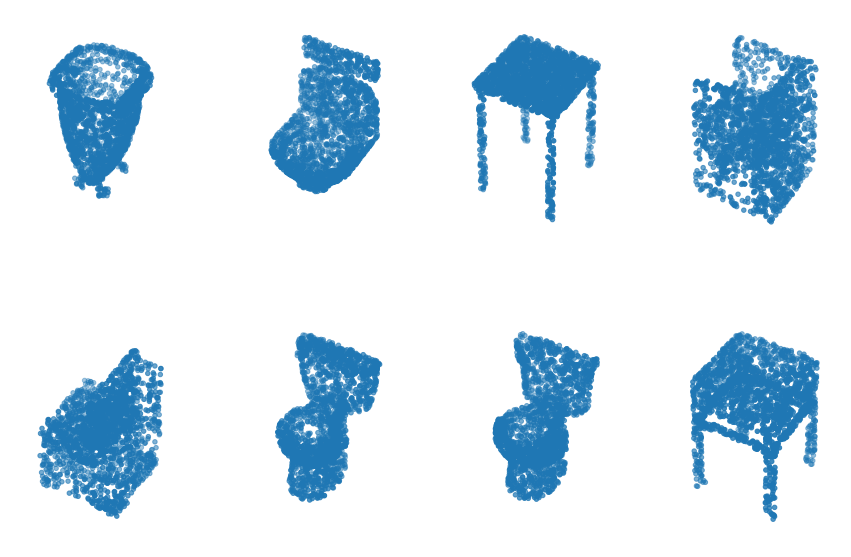

In [21]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))

for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    print("pred: {:}, label: {:}".format(CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]))
    ax.set_axis_off()
plt.show()

In [10]:
#https://stackoverflow.com/questions/45203619/how-do-i-export-point-cloud-data-project-tango-in-unity3d
#https://www.kaggle.com/kmader/point-cloud-segmentation